In [1]:
#instal libraries

#pip install sentence-transformers
#pip install umap-learn
#pip install hdbscan

In [1]:
#import libraries

import re
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#reads in california constitution

#i need to clean the data more

with open('../DATA/2022.txt', 'r') as f:
    data = f.read()

In [3]:
data

'Pandora\'s forests\nhold many dangers.\n\n\nBut the most dangerous\nthing about Pandora is…\n\n\nthat you can come to\nlike her too much.\n\n\nWe sing the chords to remember.\nEach pearl is a story from our life.\n\n\nA gem for the birth of our son.\n\n\nNot finished!\n\n\nNot finished!\n\n\nA gem for our adopted\ndaughter, Kiri, -\n\n\n- born of Grace\'s avatar, -\n\n\n- and whose conception\nwas a complete mystery.\n\n\n\n\n\n\nA gem for the first\nmeeting with Eywa.\n\n\nThe people say we\nlive in Eywa, -\n\n\n- and Eywa lives in us.\n\n\nThe almother takes care\nof all her children.\n\n\nHappiness is straightforward.\n\n\nThink a toad like\nme would find it.\n\n\nThe first time I met your\nfather, I tried to kill him.\n\n\nLove at first sight.\n\n\nBefore I knew it, we had four.\n\n\nWe sent the sky people back to\nEarth, but some stayed here.\n\n\nScientists who were\nloyal to the Na\'vi.\n\n\nAnd then there was Spider.\nHe was trapped here.\n\n\nToo young for a cryocapsule.\n\n\

In [4]:
#data cleaning

def clean(text):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    return re.sub(pattern, ' ', text)

data = clean(data)
data = data.replace('SEC.', ' ')

In [5]:
#Removes all numbers
data = ''.join([i for i in data if not i.isdigit()])

In [6]:
data = data.split("\n")    

In [7]:
data = [item for item in data if item != '']

In [8]:
data

["Pandora's forests",
 'hold many dangers.',
 'But the most dangerous',
 'thing about Pandora is…',
 'that you can come to',
 'like her too much.',
 'We sing the chords to remember.',
 'Each pearl is a story from our life.',
 'A gem for the birth of our son.',
 'Not finished!',
 'Not finished!',
 'A gem for our adopted',
 'daughter, Kiri, -',
 "- born of Grace's avatar, -",
 '- and whose conception',
 'was a complete mystery.',
 'A gem for the first',
 'meeting with Eywa.',
 'The people say we',
 'live in Eywa, -',
 '- and Eywa lives in us.',
 'The almother takes care',
 'of all her children.',
 'Happiness is straightforward.',
 'Think a toad like',
 'me would find it.',
 'The first time   met your',
 'father,   tried to kill him.',
 ' Love at first sight.',
 'Before   knew it, we had four.',
 'We sent the sky people back to',
 'Earth, but some stayed here.',
 'Scientists who were',
 "loyal to the Na'vi.",
 'And then there was Spider.',
 'He was trapped here.',
 'Too young for a cryoca

In [9]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar = True)

Batches:   0%|          | 0/488 [00:00<?, ?it/s]

In [10]:
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

In [11]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean', 
                          cluster_selection_method='eom').fit(umap_embeddings)

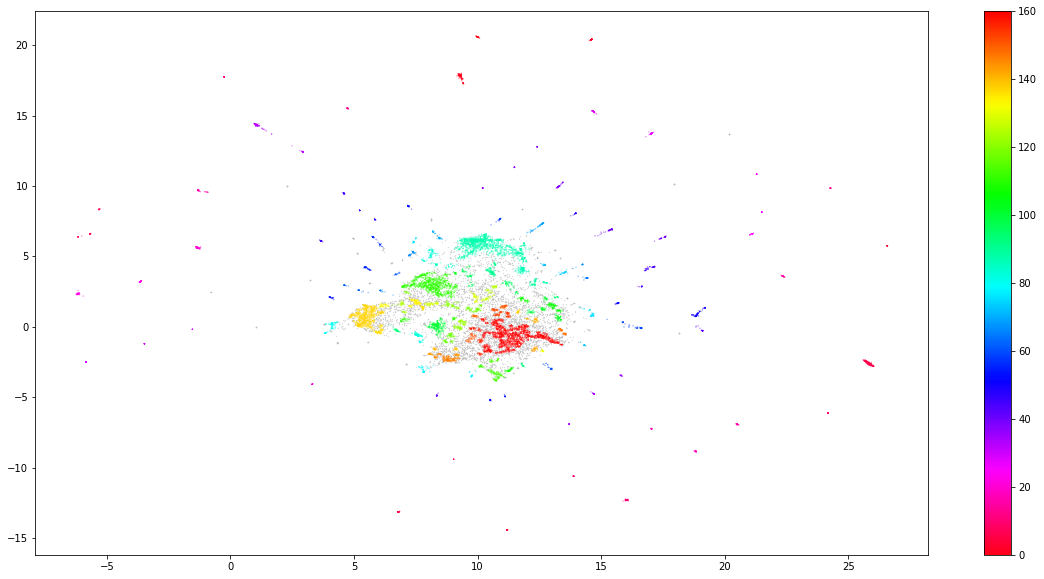

In [12]:
#umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_embeddings, columns=['x','y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20,10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [13]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [14]:
docs_per_topic

,Topic,Doc
0,-1,Pandora's forests We sing the chords to rememb...
1,0,"Denise. You remember the broad Denise, in ac..."
2,1,"Based on, Characters Created by Stan Lee an..."
3,2,HONDO HONDO HONDO HONDO HONDO HONDO HOND...
4,3,Green Rev. (//) A. Green Rev. (//) A. Green R...
...,...,...
157,156,than % chance of effectiveness. philanthropi...
158,157,( MORE) ( MORE) ( MORE) towards other world...
159,158,"Learn quickly, take your turn, and Although K..."
160,159,"The entire box must be included, Look at the ..."


In [15]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [16]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

/var/folders/sx/mxg316554p53ftfz37jrsvnr0000gn/T/ipykernel_93232/3267578824.py:5: RuntimeWarning: invalid value encountered in true_divide
  tf = np.divide(t.T, w)


In [18]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

,Topic,Size
0,-1,4299
161,160,1418
88,87,1263
111,110,910
138,137,709
7,6,265
101,100,247
147,146,170
2,1,158
33,32,152


In [19]:
len(top_n_words)

162

In [20]:
index = [160,87,110,137,6,100,146,1,32,113,20]

In [21]:
for i in index:
    print("Topic #", i-1)
    print(top_n_words[i][:7])
    print()

Topic # 159
[('got', 0.09204407782586346), ('need', 0.08272448787145414), ('just', 0.08176159260370701), ('did', 0.0784766803098549), ('know', 0.07834276953620309), ('going', 0.06866393888362333), ('want', 0.06645776468729851)]

Topic # 86
[('batman', 0.06068656038949671), ('night', 0.05562509240858922), ('int', 0.045199908598627214), ('ext', 0.03898954696730467), ('maverick', 0.03191433020471401), ('eyes', 0.026405355190200864), ('shuri', 0.026239730586790504)]

Topic # 109
[('sorry', 0.09938772685749728), ('dead', 0.08063593461466531), ('kill', 0.08035325571909879), ('wrong', 0.06153336714725935), ('bad', 0.057422396037274594), ('hard', 0.043013585546728954), ('just', 0.04000628194148961)]

Topic # 136
[('don', 0.3755166394214557), ('didn', 0.11719838421253725), ('know', 0.0899851121034778), ('wasn', 0.05388926172964542), ('doesn', 0.05034913291015407), ('isn', 0.04592662401884226), ('care', 0.04542546514605569)]

Topic # 5
[('event', 4.278078730717189), ('folks', 4.278078730717189),